In [ ]:
#|default_exp benchmarking.run_battery_on_diffusion_curvature
from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from fastcore.all import *
import numpy as np
from tqdm.auto import tqdm, trange
from nbdev import show_doc
from diffusion_curvature.utils import plot_3d
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange
from fastcore.all import *

from scipy.stats import pearsonr

import deepdish
import graphtools
from functools import partial

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import jax
import jax.numpy as jnp

def get_gpu_with_max_memory_and_set_as_default():
    devices = jax.devices("gpu")
    if not devices:
        return None

    max_memory_gpu_idx = None
    max_memory = 0

    for idx, device in enumerate(devices):
        device_mem = device.memory_stats()
        free_memory = device_mem['bytes_limit'] - device_mem['bytes_in_use']
        if free_memory > max_memory:
            max_memory = free_memory
            max_memory_gpu_idx = idx

    if max_memory_gpu_idx is not None:
        jax.config.update("jax_default_device", devices[max_memory_gpu_idx])
    
    return max_memory_gpu_idx

# Example usage
gpu_idx = get_gpu_with_max_memory_and_set_as_default()
print(f"GPU with most available memory set as default: {gpu_idx}")

GPU with most available memory set as default: 1


# 4a Computing the diffusion curvature of the battery

In [ ]:
#|export
# parameters for run
battery_file = "/home/piriac/data/diffusion_curvature/Curvature_Colosseum_dikey.h5"
# battery_file = "/home/piriac/data/diffusion_curvature/Curvature_Colosseum_LowD_HighSampled.h5" # for test runs
k = 80 # for curvature agnostic kernel
neighbor_scale = 2 # for curvature agnostic kernel
alpha = 0
ts = list(range(1,80))

name_of_run = f"DC2_with_idx_k-{k}_alpha-{alpha}_maxt-{max(ts)}"
print(name_of_run)

In [ ]:
!pixi run nbsync

In [ ]:
#|export
from diffusion_curvature.core import DiffusionCurvature2
from diffusion_curvature.kernels import get_curvature_agnostic_graph, tune_curvature_agnostic_kernel

def curvature_fn(X, dim, k = k, ts = ts, alpha = alpha, ns = neighbor_scale):
    graph_former, ns = tune_curvature_agnostic_kernel(X, k, tolerance = 1, max_iterations = 100, alpha = alpha)
    # graph_former = partial(get_curvature_agnostic_graph, k = k, neighbor_scale = neighbor_scale, alpha = alpha)
    DC = DiffusionCurvature2(
        diffusion_type = "diffusion matrix",
        laziness_method="Entropic",
        comparison_method="Subtraction",
        graph_former = graph_former,
    )
    k = DC.fit(
        X, dim, ts = ts, idx = 0
    )
    return k.item()

In [ ]:
#|export
from diffusion_curvature.utils import jax_set_best_gpu
from tqdm.auto import tqdm, trange
from diffusion_curvature.benchmarking.curvature_colosseum import compute_curvature_on_battery
from fastcore.all import *
import deepdish

@call_parse
def main():
    jax_set_best_gpu()
    # load curvature battery
    CC = deepdish.io.load(battery_file)

    saved_calcs = f"/home/piriac/data/diffusion_curvature/computed_diffusion_curvatures_core_{name_of_run}.h5"
    if os.path.exists(saved_calcs):
        print(f"Loading saved calculations from {saved_calcs}")
        computed_curvatures= deepdish.io.load(saved_calcs)
    else:
        computed_curvatures = compute_curvature_on_battery(curvature_fn, CC)
        deepdish.io.save(f"/home/piriac/data/diffusion_curvature/computed_diffusion_curvatures_core_{name_of_run}.h5", computed_curvatures)
    return CC, computed_curvatures

In [ ]:
CC, computed_curvature = main()

Loading saved calculations from /home/piriac/data/diffusion_curvature/computed_diffusion_curvatures_core_DC2_with_idx_k-10_alpha-0_maxt-19.h5


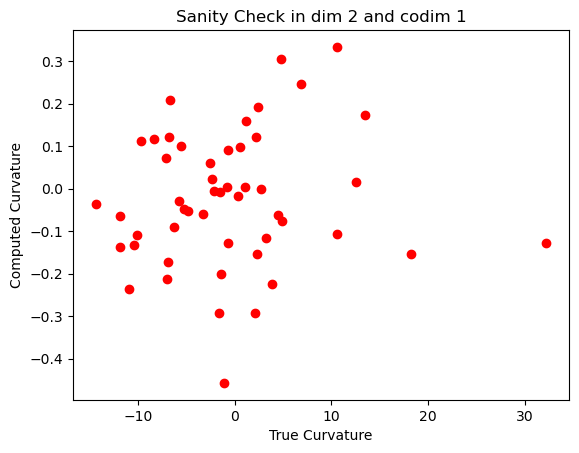

In [ ]:
d = 2
c = 1
noise_level = 0.0
plt.scatter(CC[d][c][noise_level]['k'], computed_curvature[d][c][noise_level]['k'], c = 'red')
plt.xlabel("True Curvature")
plt.ylabel("Computed Curvature")
plt.title(f"Sanity Check in dim {d} and codim {c}")
plt.show()

# Pearson Correlations

In [ ]:
#|export
# compute the pearson correlations between the computed curvature and the true curvature
def compute_correlations(
        computed_curvature, # the computed curvature
        CC, # the battery dictionary
        ):
    correlations = {}
    for d in tqdm(CC['dims'], desc="intrinsic dimensions"):
        correlations[d] = {}
        for c in tqdm(CC[d]['codims'], leave=False, desc='codimensions'):
            correlations[d][c] = {}
            for noise_level in tqdm(CC[d][c]['noise_levels'], leave=False, desc="Noise Levels"):
                correlations[d][c][noise_level] = {}
                correlations[d][c][noise_level]['r'] = []
                correlations[d][c][noise_level]['p'] = []
                # for i in trange(len(CC[d][c][noise_level]['Xs']), leave=False, desc="Samples"):
                k = computed_curvature[d][c][noise_level]['k']
                k_true = CC[d][c][noise_level]['k']
                r, p = pearsonr(k, k_true)
                correlations[d][c][noise_level]['r'] = r
                correlations[d][c][noise_level]['p'] = p
    return correlations

In [ ]:
dc_curvature_correlations = compute_correlations(computed_curvature, CC)

intrinsic dimensions:   0%|          | 0/4 [00:00<?, ?it/s]

codimensions:   0%|          | 0/4 [00:00<?, ?it/s]

Noise Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Noise Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Noise Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Noise Levels:   0%|          | 0/6 [00:00<?, ?it/s]

codimensions:   0%|          | 0/4 [00:00<?, ?it/s]

Noise Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Noise Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Noise Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Noise Levels:   0%|          | 0/6 [00:00<?, ?it/s]

codimensions:   0%|          | 0/4 [00:00<?, ?it/s]

Noise Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Noise Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Noise Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Noise Levels:   0%|          | 0/6 [00:00<?, ?it/s]

codimensions:   0%|          | 0/4 [00:00<?, ?it/s]

Noise Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Noise Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Noise Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Noise Levels:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
from tabulate import tabulate

In [ ]:
#|export
# Make a latex table of the correlations, both r and p values, with dimension in the rows and noise level in the columns
def result_table(
        correlations, # dictionary of correlations
        c:int, # codimension
        style = 'fancy_grid',
        keys = ['r','p']
        ):
    noise_levels = correlations[correlations.keys().__iter__().__next__()][c].keys()
    print("Codimension = ",c)
    table = tabulate(
        [[d] + [f"{correlations[d][c][noise_level][keys[0]]:.{3}f}{'/' + str(correlations[d][c][noise_level][keys[1]])[:4] if len(keys) > 1 else ''}" for noise_level in noise_levels] for d in correlations.keys()],
        headers=['dim'] + [f"Noise = {nl}" for nl in noise_levels],
        tablefmt=style, #latex_raw
        floatfmt=".2f",
        )
    print(table)
    return table

In [ ]:
table = result_table(dc_curvature_correlations, c=1)

Codimension =  1
╒═══════╤═══════════════╤════════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╕
│   dim │ Noise = 0.0   │ Noise = 0.05   │ Noise = 0.1   │ Noise = 0.2   │ Noise = 0.3   │ Noise = 0.5   │
╞═══════╪═══════════════╪════════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╡
│     2 │ 0.096/0.50    │ 0.017/0.90     │ -0.018/0.90   │ 0.114/0.42    │ -0.183/0.20   │ 0.121/0.40    │
├───────┼───────────────┼────────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│     3 │ -0.088/0.54   │ 0.010/0.94     │ -0.175/0.22   │ 0.006/0.96    │ -0.047/0.74   │ 0.096/0.50    │
├───────┼───────────────┼────────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│     4 │ -0.116/0.42   │ -0.193/0.17    │ -0.009/0.94   │ 0.098/0.49    │ 0.045/0.75    │ 0.073/0.61    │
├───────┼───────────────┼────────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│     5 │ 0.067/0.64

In [ ]:
table_latex = result_table(dc_curvature_correlations, c=1, style='latex_raw')

Codimension =  1
\begin{tabular}{rl}
\hline
   dim & Noise = 0.0   \\
\hline
     2 & 0.780/2.50    \\
     3 & 0.309/0.02    \\
\hline
\end{tabular}


In [ ]:
d = 2
c = 1
noise_level = 0.0
plt.scatter(CC[d][c][noise_level]['k'], computed_diffusion_curvatures[d][c][noise_level]['k'], alpha=0.1)
plt.xlabel("True Curvature")
plt.ylabel("Computed Curvature")
plt.title(f"Correlation = {dc_curvature_correlations[d][c][noise_level]['r']:.3f}")
plt.show()

NameError: name 'computed_diffusion_curvatures' is not defined

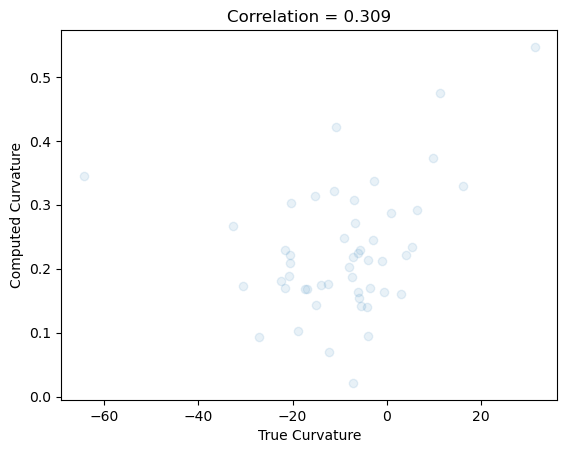

In [ ]:
d = 3
c = 1
noise_level = 0.0
plt.scatter(CC[d][c][noise_level]['k'], computed_diffusion_curvatures[d][c][noise_level]['k'], alpha=0.1)
plt.xlabel("True Curvature")
plt.ylabel("Computed Curvature")
plt.title(f"Correlation = {dc_curvature_correlations[d][c][noise_level]['r']:.3f}")
plt.show()

# Fidelity of Sign

The above shows that the *unsigned* diffusion curvature correlates robustly with the true curvature. Let's measure how well the sign is predicted by diffusion curvature. 

In [ ]:
#|export
def compute_sign_score(
        computed_curvature, # the computed curvature
        CC, # the battery dictionary
        ):
    correlations = {}
    for d in tqdm(CC['dims'], desc="intrinsic dimensions"):
        correlations[d] = {}
        for c in CC[d]['codims']:
            correlations[d][c] = {}
            for noise_level in tqdm(CC[d][c]['noise_levels'], leave=False, desc="Noise Levels"):
                correlations[d][c][noise_level] = {}
                correlations[d][c][noise_level]['r'] = []
                correlations[d][c][noise_level]['p'] = []
                # for i in trange(len(CC[d][c][noise_level]['Xs']), leave=False, desc="Samples"):
                k = computed_curvature[d][c][noise_level]['k']
                k_true = CC[d][c][noise_level]['k']
                # measure the 'classification accuracy' of the signs.
                class_acc = np.sum(
                    (np.sign(k) == np.sign(k_true)).astype(int)
                ) / len(k)
                correlations[d][c][noise_level]['accuracy'] = class_acc
    return correlations

In [ ]:
sign_accs = compute_sign_score(computed_diffusion_curvatures, CC)

intrinsic dimensions:   0%|          | 0/2 [00:00<?, ?it/s]

Noise Levels:   0%|          | 0/1 [00:00<?, ?it/s]

Noise Levels:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
table = result_table(sign_accs, c=1, keys=['accuracy'])

Codimension =  1
╒═══════╤═══════════════╕
│   dim │   Noise = 0.0 │
╞═══════╪═══════════════╡
│     2 │          0.74 │
├───────┼───────────────┤
│     3 │          0.18 │
╘═══════╧═══════════════╛


# Dataset Exploration
Dimension 3 looks terrible! Why is this?

In [ ]:
Xs = CC[3][1][0]['Xs']

In [ ]:
X = Xs[0]
G = get_adaptive_graph(X) #graphtools.Graph(X, anisotropy=1, knn=15, decay=None).to_pygsp()
DC = DiffusionCurvature(
    laziness_method="Entropic",
    flattening_method="Fixed",
    comparison_method="Subtraction",
    graph_former = get_adaptive_graph,
    points_per_cluster=None, # construct separate comparison spaces around each point
    comparison_space_size_factor=1
)
ks = DC.curvature(G, t=15, dim=3)
plot_3d(X, ks, use_plotly=True)

TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
#|hide
!nbdev_export